In [1]:
from pyspark.context import SparkContext
sc = SparkContext('local[*]', 'test')

In [2]:
from pyspark.sql import SQLContext
spark = SQLContext(sc)

In [3]:
from pyspark.sql.types import *

struct_schema_data =  StructType([
    StructField('age', IntegerType(), True),
    StructField('workclass', StringType(), True),
    StructField('fnlwgt', FloatType(), True),
    StructField('education', StringType(), True),
    StructField('education_num', FloatType(), True),
    StructField('marital_status', StringType(), True),
    StructField('occupation', StringType(), True),
    StructField('relationship', StringType(), True),
    StructField('race', StringType(), True),
    StructField('sex', StringType(), True),
    StructField('capital_gain', FloatType(), True),
    StructField('capital_loss', FloatType(), True),
    StructField('hours_per_week', FloatType(), True),
    StructField('native_country', StringType(), True),
    StructField('salary', StringType(), True)
])


In [4]:
from pyspark.sql import functions as F
df_data = spark.read.csv('adult.data', header=False, schema=struct_schema_data)
df_test = spark.read.csv('adult.test', header=False, schema=struct_schema_data)
df_test = df_test.withColumn('salary',F.when(F.col("salary")==' <=50K.',' <=50K').otherwise(' >50K'))

In [5]:
df_data = df_data.withColumn('target',F.when(F.col("salary")==' <=50K', 0).otherwise(1))
df_test = df_test.withColumn('target',F.when(F.col("salary")==' <=50K', 0).otherwise(1))

<AxesSubplot:>

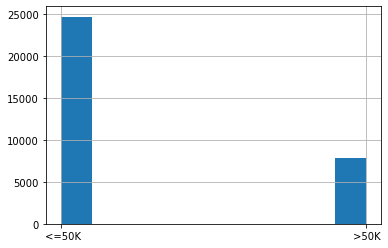

In [6]:
df_data.toPandas()['salary'].hist()

In [7]:
df_data.toPandas().describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,target
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897779e+05,10.080679,1077.649170,87.303833,40.437454,0.240810
std,13.640433,1.055497e+05,2.572562,7385.911621,403.014771,12.347933,0.427581
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


In [8]:
df_data.toPandas().dtypes

age                 int32
workclass          object
fnlwgt            float32
education          object
education_num     float32
marital_status     object
occupation         object
relationship       object
race               object
sex                object
capital_gain      float32
capital_loss      float32
hours_per_week    float32
native_country     object
salary             object
target              int32
dtype: object

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|             32561|
|   mean| 38.58164675532078|
| stddev|13.640432553581356|
|    min|                17|
|    max|                90|
+-------+------------------+



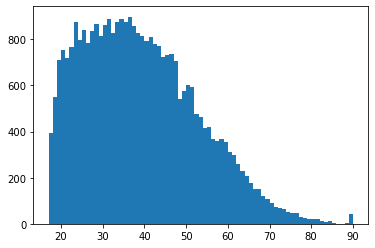

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

df_data.createOrReplaceTempView('data')

total_ages = spark.sql("select count(distinct(age)) as total from data").collect()[0].total
ages_rows_hist = spark.sql("select age from data").collect()
ages_hist = [row.age for row in ages_rows_hist]

plt.hist(ages_hist, bins=total_ages)
df_data.selectExpr('age').describe().show()


In [10]:
total_age_low = spark.sql("select count(*) as total from data where age<=30").collect()[0].total
total_age_middle = spark.sql("select count(*) as total from data where age>30 and age<=45").collect()[0].total
total_age_high = spark.sql("select count(*) as total from data where age>45").collect()[0].total
print(total_age_high, total_age_middle, total_age_low)

9627 12362 10572


+-------+------------------+
|summary|    hours_per_week|
+-------+------------------+
|  count|             32561|
|   mean|40.437455852092995|
| stddev|12.347428681731838|
|    min|               1.0|
|    max|              99.0|
+-------+------------------+



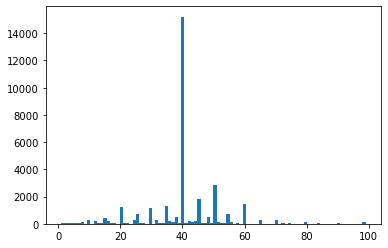

In [11]:

total_hours = spark.sql("select count(distinct(hours_per_week)) as total from data").collect()[0].total
hours_rows_hist = spark.sql("select hours_per_week from data").collect()
hours_hist = [row.hours_per_week for row in hours_rows_hist]

plt.hist(hours_hist, bins=total_hours)
df_data.selectExpr('hours_per_week').describe().show()


In [12]:
total_hours_low = spark.sql("select count(*) as total from data where hours_per_week<=38").collect()[0].total
total_hours_middle = spark.sql("select count(*) as total from data where hours_per_week>38 and hours_per_week<=42").collect()[0].total
total_hours_high = spark.sql("select count(*) as total from data where hours_per_week>42").collect()[0].total
print(total_hours_high, total_hours_middle, total_hours_low)

9326 15510 7725


+-------+----------------+
|summary|    capital_loss|
+-------+----------------+
|  count|           32561|
|   mean| 87.303829734959|
| stddev|402.960218649002|
|    min|             0.0|
|    max|          4356.0|
+-------+----------------+



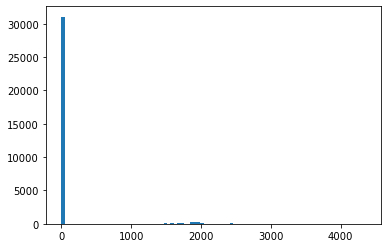

In [13]:
total_capital_gain = spark.sql("select count(distinct(capital_loss)) as total from data").collect()[0].total
capital_gain_rows_hist = spark.sql("select capital_loss from data").collect()
capital_gain_hist = [row.capital_loss for row in capital_gain_rows_hist]

plt.hist(capital_gain_hist, bins=total_capital_gain)
df_data.selectExpr('capital_loss').describe().show()


In [14]:
spark.sql("select count(*) as total from data where capital_gain>0").collect()[0].total

2712

In [17]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import QuantileDiscretizer

age_discretizer = QuantileDiscretizer(numBuckets=4, inputCol="age", outputCol="ageIndex")


from pyspark.ml.feature import Bucketizer
# La variable 'age' se discretiza en quintiles y hours-per-week en buckets (0,38], (38,42], (42, infty] considerando que 
# asi podriamos diferenciar entre medias jornadas, jornadas completas y gente que trabaja en jornadas extendidas o mas
# de un trabajo.
hours_splits = [-float("inf"), 36, 44, float("inf")]
hours_bucketizer = Bucketizer(splits=hours_splits, inputCol='hours_per_week', outputCol="hoursIndex")

#Las variables de ganancia y perdida de capital se separan entre auqellos que ganan catila o no, y auqllos que pierden capital o no
#para ser coherentes con la distribucion
capital_splits = [-float("inf"), 0, float("inf")]
cg_bucketizer = Bucketizer(splits=capital_splits, inputCol="capital_gain", outputCol="gainIndex")
cl_bucketizer = Bucketizer(splits=capital_splits, inputCol="capital_loss", outputCol="lossIndex")


from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[age_discretizer, hours_bucketizer, cg_bucketizer, cl_bucketizer])

In [18]:
model_discretization = pipeline.fit(df_data)
df_data = model_discretization.transform(df_data)

In [19]:
df_data = df_data.drop('age', 'hours_per_week', 'capital_gain', 'capital_loss', 'salary', 'fnlwgt')
df_data.toPandas()

,workclass,education,education_num,marital_status,occupation,relationship,race,sex,native_country,target,ageIndex,hoursIndex,gainIndex,lossIndex
0,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,0,2.0,1.0,1.0,1.0
1,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,0,3.0,0.0,1.0,1.0
2,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,0,2.0,1.0,1.0,1.0
3,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,0,3.0,1.0,1.0,1.0
4,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,Private,Assoc-acdm,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,United-States,0,0.0,1.0,1.0,1.0
32557,Private,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States,1,2.0,1.0,1.0,1.0
32558,Private,HS-grad,9.0,Widowed,Adm-clerical,Unmarried,White,Female,United-States,0,3.0,1.0,1.0,1.0
32559,Private,HS-grad,9.0,Never-married,Adm-clerical,Own-child,White,Male,United-States,0,0.0,0.0,1.0,1.0


In [103]:
import math


def entropy(probabs):
    return -sum([ p * math.log(p,2) for p in probabs])


def entropy_from_values(values):
    sum_values = sum(values)
    probabilities = [value/sum_values for value in values]
    return entropy(probabilities)



def attribute_values(table_collected, attribute, distinct_attribute_values):
    counts_and_totals = []
    
    for attr_value in distinct_attribute_values:
        values_attr = [row['count'] for row in table_collected if row[attribute]==attr_value]
        sum_values_attr = sum(values_attr)
        counts_and_totals = counts_and_totals + [(values_attr, sum_values_attr)]
    
    return counts_and_totals



def weighted_entropy_table(table_collected, attribute):
    distinct_attribute_values = set([row[attribute] for row in table_collected])
    attr_values = attribute_values(table_collected, attribute, distinct_attribute_values)
    sum_splits = sum([totals for values, totals in attr_values])
    
    return sum([(entropy_from_values(values)* totals)/sum_splits for values, totals in attr_values])


def weighted_entropy_for_attribute(df_train, attribute, target):
    table_collected = df_train.groupby(attribute,target).count().sort(attribute).collect()
    return weighted_entropy_table(table_collected,attribute)


###################################3 UNWEIGHTED

def unweighted_entropy_table(table_collected, attribute):
    distinct_attribute_values = set([row[attribute] for row in table_collected])
    attr_values = attribute_values(table_collected, attribute, distinct_attribute_values)
    sum_splits = sum([totals for values, totals in attr_values])
    
    return sum([ entropy_from_values(values) for values, totals in attr_values])


def unweighted_entropy_for_attribute(df_train, attribute, target):
    table_collected = df_train.groupby(attribute,target).count().sort(attribute).collect()
    return unweighted_entropy_table(table_collected,attribute)



In [104]:
def gain_ratio(df, target, att):
    entropy = entropy_from_values([r['count'] for r in df.select(target).groupby(target).count().sort(target).collect()])
    info_gain = entropy-weighted_entropy_for_attribute(df, att, target)
    unweighted_entropy_att = unweighted_entropy_for_attribute(df, att, target)
    return info_gain / unweighted_entropy_att

In [110]:
def train_ig(train_dataframe, feature_columns_list, target='target', min_ig_threshold=0.00001, max_depth=7, min_instances=20):
    
    feature_columns = {}
    for feature in feature_columns_list:
        feature_columns[feature] = [r[feature] for r in train_dataframe.select(F.col(feature)).distinct().collect()]
    
    train_dataframe = train_dataframe.select(feature_columns_list+[target])
    
    return train_recursive_ig(train_dataframe, feature_columns, target, min_ig_threshold, max_depth, min_instances, 0)


In [121]:
from copy import deepcopy
def train_recursive_ig(train_dataframe, feature_columns, target, min_ig_threshold, max_depth, min_instances, depth):
    if len(feature_columns) == 0 or train_dataframe.count() < min_instances or depth >= max_depth:
        table_collected = train_dataframe.groupby(target).count().sort(target).collect()
        return calculate_final_probability(table_collected)
        
                
    entropy = entropy_from_values([r['count'] for r in train_dataframe.select(target).groupby(target).count().sort(target).collect()])
    info_gain = [(entropy-weighted_entropy_for_attribute(train_dataframe, att, target), att) for att in list(feature_columns.keys())]

    max_ig = sorted(info_gain, key = lambda x : x[0], reverse=True)[0][0]
    
    if max_ig > min_ig_threshold: 
        att_split = sorted(info_gain, key = lambda x : x[0])[0][1]

        att_split_values = feature_columns.pop(att_split)

        node_dict = {}

        for att in att_split_values:

            next_df = train_dataframe.select(list(feature_columns.keys())+[target]).where(F.col(att_split) == att)
            next_feature = deepcopy(feature_columns)

            if next_df.count() > 0: 
                node_dict[att] = train_recursive_ig(next_df, next_feature, target, min_ig_threshold, max_depth, min_instances, depth+1)
            else :
                node_dict[att] = calculate_final_probability(
                    train_dataframe.groupby(target).count().sort(target).collect())


        return (att_split, node_dict)
    
    else:
        return calculate_final_probability(
                    train_dataframe.groupby(target).count().sort(target).collect())
        

In [122]:
def calculate_final_probability(table_collected):
#     print(table_collected)
    if len(table_collected) == 2 :
        negative = table_collected[0]['count']
        positive = table_collected[1]['count']
        total = positive + negative
        pos_prob = positive / total
        neg_prob = negative / total
        prediction = 1 if pos_prob >= neg_prob else 0
        
    else:
#         En este caso, solo existen instancias con uno de los dos posibles valores de 'target'
        prediction = 0 if table_collected[0]['target'] == 0.0 else 1
        pos_prob = 1 if prediction == 1 else 0
        neg_prob = 1 - pos_prob
        
    return [neg_prob, pos_prob, prediction]

In [123]:
df_data.printSchema()

root
 |-- workclass: string (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: float (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- native_country: string (nullable = true)
 |-- target: integer (nullable = false)
 |-- ageIndex: double (nullable = true)
 |-- hoursIndex: double (nullable = true)
 |-- gainIndex: double (nullable = true)
 |-- lossIndex: double (nullable = true)



In [124]:
target = 'target'

In [29]:
entropies = [(weighted_entropy_for_attribute(df_data, i), i) for i in df_data.columns]
sorted(entropies, key = lambda x : x[0])

[(0.0, 'target'),
 (0.6310181972169983, 'relationship'),
 (0.6398560900765513, 'marital_status'),
 (0.7027931141135987, 'education_num'),
 (0.7027931141135988, 'education'),
 (0.7034614712472426, 'occupation'),
 (0.712597707130994, 'ageIndex'),
 (0.7421071509783821, 'hoursIndex'),
 (0.7592125677638919, 'sex'),
 (0.7748123650040905, 'workclass'),
 (0.7876886131813519, 'native_country'),
 (0.7880060088737028, 'race'),
 (0.7963839552022132, 'gainIndex'),
 (0.7963839552022132, 'lossIndex')]

In [30]:
gain_ratios = [(gain_ratio(df_data, target, i), i) for i in df_data.columns if i != target]
sorted(gain_ratios, key = lambda x : x[0], reverse = True)

[(0.05261967890510802, 'relationship'),
 (0.04009598959410048, 'marital_status'),
 (0.02957846961897232, 'ageIndex'),
 (0.026809948369478122, 'sex'),
 (0.025351801065995664, 'hoursIndex'),
 (0.01067534829970946, 'education_num'),
 (0.01067534829970945, 'education'),
 (0.009902821282439559, 'occupation'),
 (0.0037363018975513306, 'workclass'),
 (0.002653802742315333, 'race'),
 (0.0003206675687525654, 'native_country'),
 (0.0, 'gainIndex'),
 (0.0, 'lossIndex')]

In [144]:
features = ['relationship', 'marital_status', 'ageIndex', 'sex','hoursIndex', 'education_num', 'education', 'occupation']

In [145]:
import time
duration = time.time()
tree = train_ig(df_data,features , target, min_ig_threshold=0.0005, max_depth=4, min_instances=15 )
duration = time.time() - duration 

In [146]:
duration, tree

(978.7770247459412,
 ('sex',
  {' Male': ('hoursIndex',
    {0.0: ('occupation',
      {' Farming-fishing': ('ageIndex',
        {0.0: [1, 0, 0],
         1.0: [1, 0, 0],
         3.0: [0.9583333333333334, 0.041666666666666664, 0],
         2.0: [0.9642857142857143, 0.03571428571428571, 0]}),
       ' Handlers-cleaners': ('education_num',
        {9.0: [0.9897959183673469, 0.01020408163265306, 0],
         5.0: [1, 0, 0],
         11.0: [1, 0, 0],
         7.0: [1, 0, 0],
         2.0: [1, 0, 0],
         14.0: [1, 0, 0],
         3.0: [1, 0, 0],
         10.0: [0.9857142857142858, 0.014285714285714285, 0],
         12.0: [1, 0, 0],
         6.0: [0.9230769230769231, 0.07692307692307693, 0],
         1.0: [1, 0, 0],
         8.0: [1, 0, 0],
         16.0: [0.9859649122807017, 0.014035087719298246, 0],
         15.0: [0.9859649122807017, 0.014035087719298246, 0],
         4.0: [1, 0, 0],
         13.0: [0.875, 0.125, 0]}),
       ' Prof-specialty': ('ageIndex',
        {0.0: [0.98888888

In [35]:
df_test = model_discretization.transform(df_test)

In [147]:
def predict(tree, feature_columns):
  
    while len(feature_columns) > 0 and type(tree) != list:
        tree = tree[1][feature_columns.pop(tree[0], None)]
    
    return tree[0], tree[1], tree[2]


In [148]:
predictions = []

for instance in df_test.toPandas()[features + [target]].to_records():
    cols_to_predict = {k:v for k,v in zip(features, instance.tolist()[1:-1])}
    predictions += [predict(tree, cols_to_predict)]
    

In [149]:
dt_test_pd = df_test.toPandas()

In [150]:
dt_test_pd[['neg_prob', 'pos_prob', 'prediction']] = predictions

In [151]:
dt_test_pd

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,...,native_country,salary,target,ageIndex,hoursIndex,gainIndex,lossIndex,neg_prob,pos_prob,prediction
0,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,...,United-States,<=50K,0,0.0,1.0,1.0,1.0,0.961905,0.038095,0
1,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,...,United-States,<=50K,0,2.0,2.0,1.0,1.0,0.365433,0.634567,1
2,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,...,United-States,>50K,1,1.0,1.0,1.0,1.0,0.694693,0.305307,0
3,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,...,United-States,>50K,1,2.0,1.0,1.0,1.0,0.527803,0.472197,0
4,18,?,103497.0,Some-college,10.0,Never-married,?,Own-child,White,Female,...,United-States,<=50K,0,0.0,0.0,1.0,1.0,0.991228,0.008772,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,...,United-States,<=50K,0,2.0,1.0,1.0,1.0,0.756906,0.243094,0
16277,64,?,321403.0,HS-grad,9.0,Widowed,?,Other-relative,Black,Male,...,United-States,<=50K,0,3.0,1.0,1.0,1.0,0.744681,0.255319,0
16278,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,...,United-States,<=50K,0,2.0,2.0,1.0,1.0,0.365433,0.634567,1
16279,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,...,United-States,<=50K,0,2.0,1.0,1.0,1.0,0.894022,0.105978,0


In [152]:
import numpy as np
dt_test_pd['pred_th'] = np.where(dt_test_pd['pos_prob'] > 0.15, 1, 0)

In [153]:
dt_test_pd

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,...,salary,target,ageIndex,hoursIndex,gainIndex,lossIndex,neg_prob,pos_prob,prediction,pred_th
0,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,...,<=50K,0,0.0,1.0,1.0,1.0,0.961905,0.038095,0,0
1,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,...,<=50K,0,2.0,2.0,1.0,1.0,0.365433,0.634567,1,1
2,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,...,>50K,1,1.0,1.0,1.0,1.0,0.694693,0.305307,0,1
3,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,...,>50K,1,2.0,1.0,1.0,1.0,0.527803,0.472197,0,1
4,18,?,103497.0,Some-college,10.0,Never-married,?,Own-child,White,Female,...,<=50K,0,0.0,0.0,1.0,1.0,0.991228,0.008772,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,...,<=50K,0,2.0,1.0,1.0,1.0,0.756906,0.243094,0,1
16277,64,?,321403.0,HS-grad,9.0,Widowed,?,Other-relative,Black,Male,...,<=50K,0,3.0,1.0,1.0,1.0,0.744681,0.255319,0,1
16278,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,...,<=50K,0,2.0,2.0,1.0,1.0,0.365433,0.634567,1,1
16279,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,...,<=50K,0,2.0,1.0,1.0,1.0,0.894022,0.105978,0,0


In [154]:
dt_test_pd[['target', 'prediction', 'pred_th']]

,target,prediction,pred_th
0,0,0,0
1,0,1,1
2,1,0,1
3,1,0,1
4,0,0,0
...,...,...,...
16276,0,0,1
16277,0,0,1
16278,0,1,1
16279,0,0,0


In [155]:
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

def get_scores(Y_pred, probs, Y_test, plot=True):

    # Calcular TP, TN, FP, FN
    # Armar matriz de cofusion
    # Recall, Precision, Accuracy, F1
    # AUC
    # probas = model.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(Y_test,probs[:,1])
    if plot:
        plt.plot([0,1],[0,1],'k--') #se grafica la linea diagonal
        plt.plot(fpr, tpr, label='NB') #se grafica la curva ROC
        plt.xlabel('fpr')
        plt.ylabel('tpr')
        plt.show()
        print("AUC: {}" .format(auc(fpr, tpr)))

    accuracy = accuracy_score(Y_test, Y_pred)


    mat = confusion_matrix(Y_test, Y_pred)
    if plot:
        print (classification_report(Y_test,Y_pred))
        sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
        plt.xlabel('Clase de test')
        plt.ylabel('Clase de la predicción');

    return accuracy

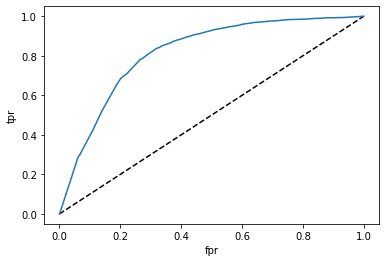

AUC: 0.8160065099829565
              precision    recall  f1-score   support

           0       0.81      0.93      0.87     12435
           1       0.58      0.30      0.39      3846

    accuracy                           0.78     16281
   macro avg       0.70      0.62      0.63     16281
weighted avg       0.76      0.78      0.76     16281



0.7833671150420736

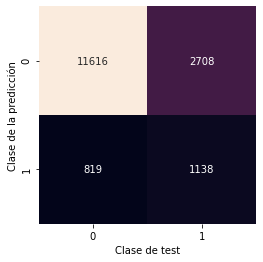

In [156]:
get_scores(list(dt_test_pd['prediction']), np.array([[n,p] for i,n,p in dt_test_pd[['neg_prob', 'pos_prob']].to_records()]), list(dt_test_pd['target']), plot=True)

In [102]:
df_data.count()

32561